In [1]:

from __future__ import annotations

import argparse
from dataclasses import dataclass
from pathlib import Path
from typing import List, Sequence

import numpy as np
import pandas as pd
import torch
import sys
sys.path.append("../../CausalPFN")
from src.causalpfn import CATEEstimator
# from causalpfn import CATEEstimator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



/opt/anaconda3/envs/csc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

REPO_ROOT = Path("./").absolute()
DATA_DIR = REPO_ROOT / "data" / "shrug"
DEFAULT_CSV = DATA_DIR / "full_dataset.csv"
DEFAULT_FEATURE_DIR = DATA_DIR / "features"
PLOT_DIR = REPO_ROOT / "plots_shrug" / "training_curves"
DROP_ORDER_INFO = [
    ("urban", 0.1, "urban / village"),
    ("tot_p", 0.1, "total population"),
    ("tot_f", 0.1, "total fat?")
]
DROP_ORDER = [name for name, _, _ in DROP_ORDER_INFO]
DROP_DESCRIPTIONS = {name: desc for name, _, desc in DROP_ORDER_INFO}


In [3]:
class Args:
    def __init__(self):
        self.csv_path = DEFAULT_CSV
        self.feature_dir = DEFAULT_FEATURE_DIR
        self.val_fraction = 0.2
        self.random_state = 42
        self.embedding_dim = 32
        self.pca = False
        self.joint_embedding = True
        self.embedding_epochs = 300
        self.embedding_lr = 0.0001
        self.cate_max_steps = None
        self.standardize = False

args = Args()

In [4]:
from linear_fit import *

data loading and preprocess

In [5]:
df = load_tabular_data(args.csv_path)
true_cate = load_true_cate(args.csv_path)
if true_cate is not None and len(true_cate) != len(df):
    print(
        f"Warning: cate.txt contains {len(true_cate)} rows but dataset has {len(df)}; "
        "skipping PEHE computation."
    )
    true_cate = None
elif true_cate is None:
    print(
        f"Warning: cate.txt not found in {args.csv_path.parent}; "
        "skipping PEHE computation."
    )
else:
    print("TRUE CATE:", true_cate.mean(), true_cate.std())

ordered_covs = [c for c in DROP_ORDER if c in df.columns]
other_covs = [
    c
    for c in df.columns
    if c not in {"row_id", "treatment", "outcome"} and c not in ordered_covs
]
covariates = ordered_covs + other_covs
print(f"Loaded {len(df)} rows with {len(covariates)} covariates.")

row_ids = df["row_id"].astype(int).tolist()
features = load_feature_matrix(args.feature_dir, row_ids)
print(f"Feature matrix shape: {features.shape}")

indices = np.arange(len(df))
train_idx, val_idx = train_test_split(
    indices,
    test_size=args.val_fraction,
    random_state=args.random_state,
    shuffle=True,
    stratify=df["treatment"]
)

if args.standardize:
    print("standardize feature")
    train_features = features[train_idx]
    scaler = StandardScaler()
    scaler.fit(train_features)
    features = scaler.transform(features)

scaler = StandardScaler()
scaler.fit(df.loc[train_idx, covariates].to_numpy(dtype=float))
df.loc[:, covariates] = scaler.transform(df[covariates].to_numpy(dtype=float))

y = df["outcome"].to_numpy(dtype=float)

treatment = df["treatment"].astype(float).to_numpy()

print(
    f"Train/val split: {len(train_idx)} train / {len(val_idx)} val "
    f"(val frac={args.val_fraction:.2f})"
)

Loaded 6055 rows with 3 covariates.
Feature matrix shape: (6055, 4000)
Train/val split: 4844 train / 1211 val (val frac=0.20)


In [36]:
df

,row_id,urban,tot_p,tot_f,treatment,outcome
0,0,0,-0.512901,-0.069166,0.0,0
1,1,0,-0.340982,-0.296273,0.0,1
2,2,0,-0.472799,0.123807,0.0,1
3,3,0,-0.088488,-0.141045,0.0,0
4,4,0,-0.272289,-0.532896,0.0,0
...,...,...,...,...,...,...
6050,6050,0,-0.610928,0.234498,1.0,1
6051,6051,0,0.333697,0.068007,1.0,0
6052,6052,0,-0.151611,-0.152124,1.0,0
6053,6053,0,0.234184,-0.040987,1.0,0


In [37]:
features.shape

(6055, 4000)

## Experiment 1: Linear Regression (Covariates + Treatment -> Outcome)

In [6]:
model = LinearRegression()
X = df[covariates + ["treatment"]].to_numpy()
Y = df['outcome'].to_numpy()
model.fit(X[train_idx], Y[train_idx])
preds = model.predict(X[val_idx])

Text(0.5, 1.0, 'Linear Regression Result - All covariates (R^2=0.03)')

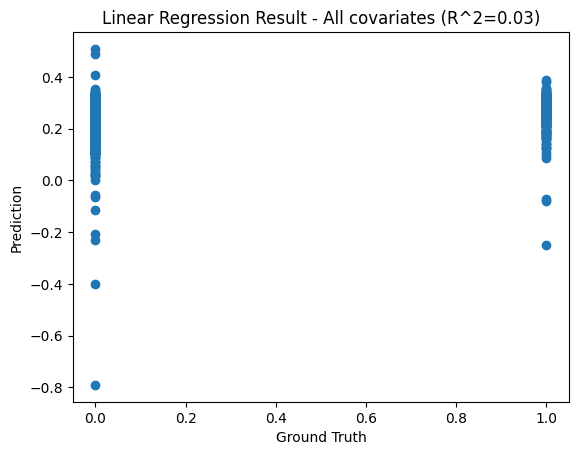

In [7]:
import matplotlib.pyplot as plt
plt.scatter(Y[val_idx], preds)

plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.title("Linear Regression Result - All covariates (R^2={:.2f})".format(r2_score(Y[val_idx], preds)))

experiment on all data 


Experiments (validation MAE | R^2):
[Covariate masking] baseline           -> MAE=0.3533 | R^2=0.0347 | remaining=3
[Covariate masking] drop urban         -> MAE=0.3533 | R^2=0.0347 | remaining=2
[Covariate masking] drop tot_p         -> MAE=0.3600 | R^2=0.0058 | remaining=1
[Covariate masking] drop tot_f         -> MAE=0.3602 | R^2=0.0070 | remaining=0


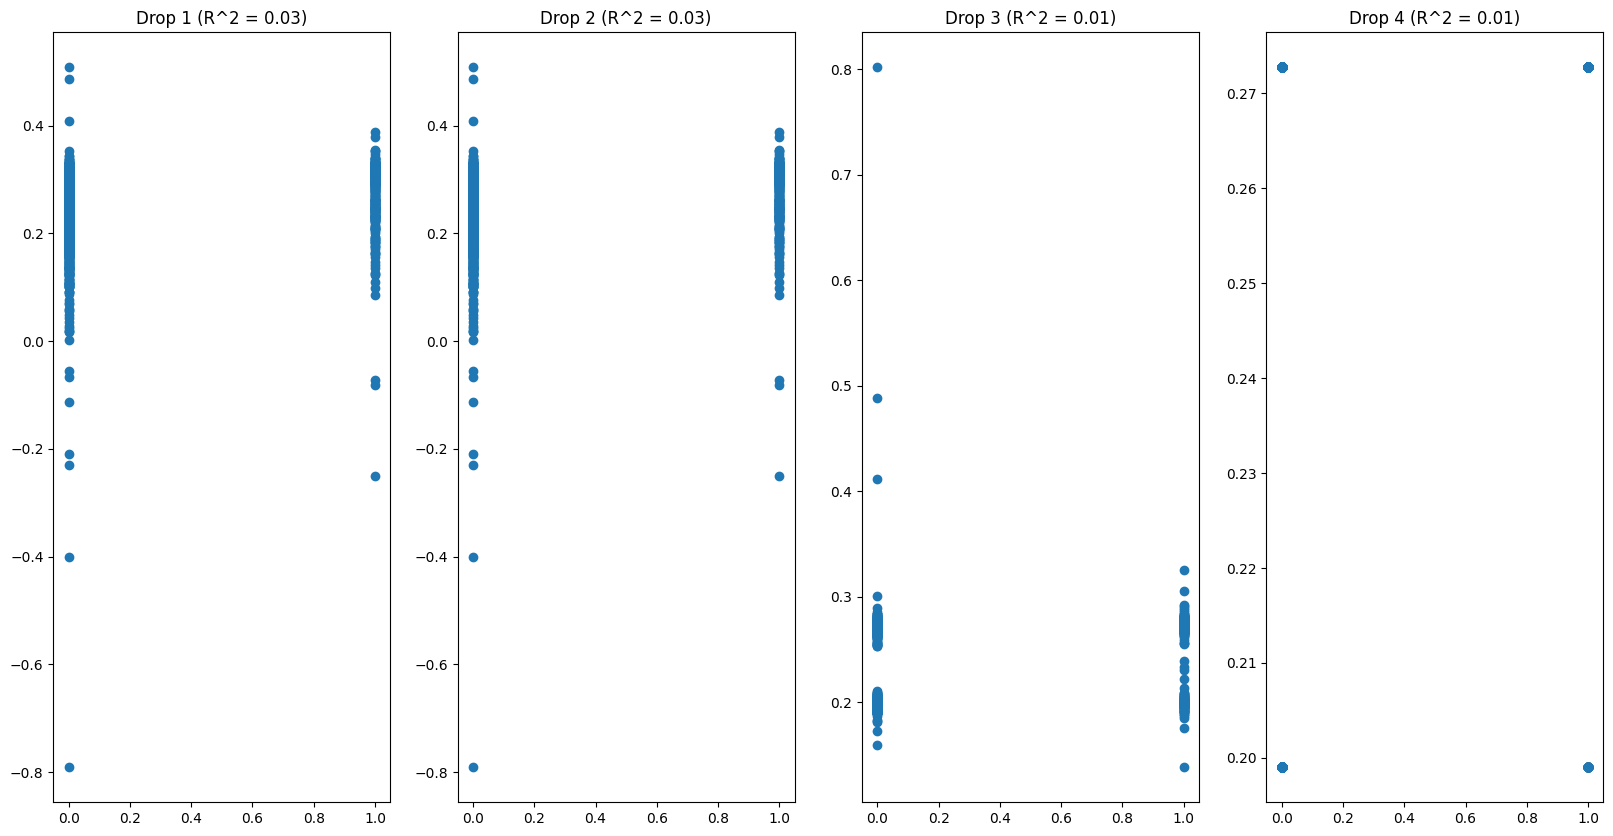

In [10]:
print("\nExperiments (validation MAE | R^2):")
cov_results = covariate_masking_experiments(
    df, covariates, train_idx, val_idx, drop_order=DROP_ORDER
)
fig, axes = plt.subplots(1, 4)
fig.set_figheight(10)
fig.set_figwidth(20)
for i, res in enumerate(cov_results):
    print(
        f"[Covariate masking] {res.label:<18} -> "
        f"MAE={res.mae:.4f} | R^2={res.r2:.4f} | "
        f"remaining={len(res.remaining_covariates)}"
    )
    axes[i].scatter(df['outcome'][val_idx], res.preds)
    axes[i].set_title("Drop {} (R^2 = {:.2f})".format(i+1, res.r2))
    

## Experiment 2: CausalPFN (Covariates + Treatment -> Outcome)

Text(0, 0.5, 'Prediction')

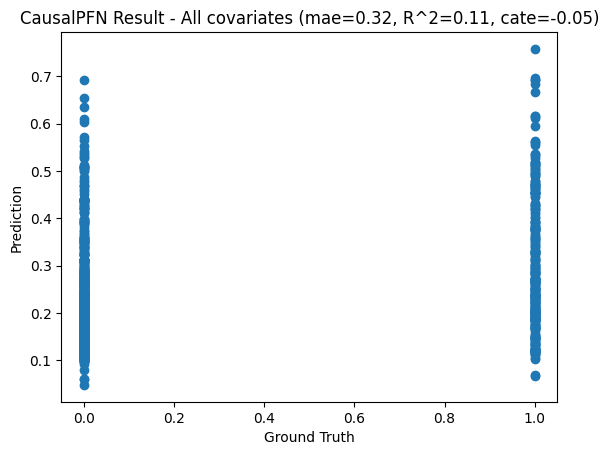

In [17]:
# one example
from linear_fit import _predict_potential_outcomes
X = df[covariates].to_numpy()
T = df['treatment'].to_numpy()
Y = df["outcome"].to_numpy()
estimator = CATEEstimator(device='cpu')
X_train = X[train_idx]
T_train = T[train_idx]
Y_train = Y[train_idx]
estimator.fit(X_train, T_train, Y_train)

mu0, mu1 = _predict_potential_outcomes(estimator, X[val_idx])
t_val = treatment[val_idx]
y_val = Y[val_idx]
y_pred = np.where(t_val >= 0.5, mu1, mu0)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
cate = mu1 - mu0

# pehe = compute_pehe(cate, true_cate[val_idx])

plt.scatter(y_val, y_pred)
plt.title("CausalPFN Result - All covariates (mae={:.2f}, R^2={:.2f}, cate={:.2f})".format(mae, r2, np.mean(cate)))
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")

In [23]:

def run_cate_masking_experiments(
    df: pd.DataFrame,
    schedule: List[ExperimentResult],
    treatment: np.ndarray,
    outcome: np.ndarray,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    extra_features: np.ndarray | None,
    true_cate: np.ndarray | None,
    label_prefix: str,
    max_steps: int | None = None,
    standardize: bool = False
) -> None:
    n_cols = 3
    n_rows = len(schedule) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols)
    fig.set_figheight(16)
    fig.set_figwidth(20)

    if standardize:
        outcome = outcome.reshape(-1, 1)
        scalar = StandardScaler()
        scalar.fit(outcome[train_idx])
        outcome = scalar.transform(outcome)
        print(scalar.mean_, scalar.scale_)
        outcome = outcome.reshape(-1)
        
    for idx, res in enumerate(schedule):
        if max_steps is not None and idx >= max_steps:
            break
        if res.remaining_covariates:
            X_tabular = df[res.remaining_covariates].to_numpy(dtype=float)
        else:
            X_tabular = np.empty((len(df), 0), dtype=float)

        if extra_features is not None:
            X = np.concatenate([X_tabular, extra_features], axis=1)
        else:
            if X_tabular.shape[1] == 0:
                # Provide a constant feature so the estimator can still run.
                X = np.ones((len(df), 1), dtype=float)
            else:
                X = X_tabular
        X = X.astype(np.float32, copy=False)
        y_pred, mae, r2, cate = fit_and_score_cate(X, treatment, outcome, train_idx, val_idx)
        if standardize:
            cate = cate * scalar.scale_
            
        metrics = (
            f"{label_prefix} {res.label:<18} -> MAE={mae:.4f} | R^2={r2:.4f} | "
            f"CATE mean={cate.mean():.4f} std={cate.std():.4f}"
        )
        # pehe = compute_pehe(cate, true_cate[val_idx])
        # metrics = f"{metrics} | PEHE={pehe:.4f}"
        
        print(
            metrics
        )

        axes[idx].scatter(df['outcome'][val_idx], y_pred)
        axes[idx].set_title("Drop {} (R^2 = {:.2f})".format(i+1, r2))
    


[CATE covs] baseline           -> MAE=0.3221 | R^2=0.1104 | CATE mean=-0.0542 std=0.0570
[CATE covs] drop urban         -> MAE=0.3247 | R^2=0.1063 | CATE mean=-0.0525 std=0.0536


OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 128 or lower
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 128 or lower
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set

BLAS : Bad memory unallocation! :  768  0x534000000
BLAS : Bad memory unallocation! :  768  0x52a000000
[CATE covs] drop tot_p         -> MAE=0.3438 | R^2=0.0420 | CATE mean=-0.0537 std=0.0418
[CATE covs] drop tot_f         -> MAE=0.3585 | R^2=0.0071 | CATE mean=-0.0910 std=0.0000


IndexError: index 3 is out of bounds for axis 0 with size 3

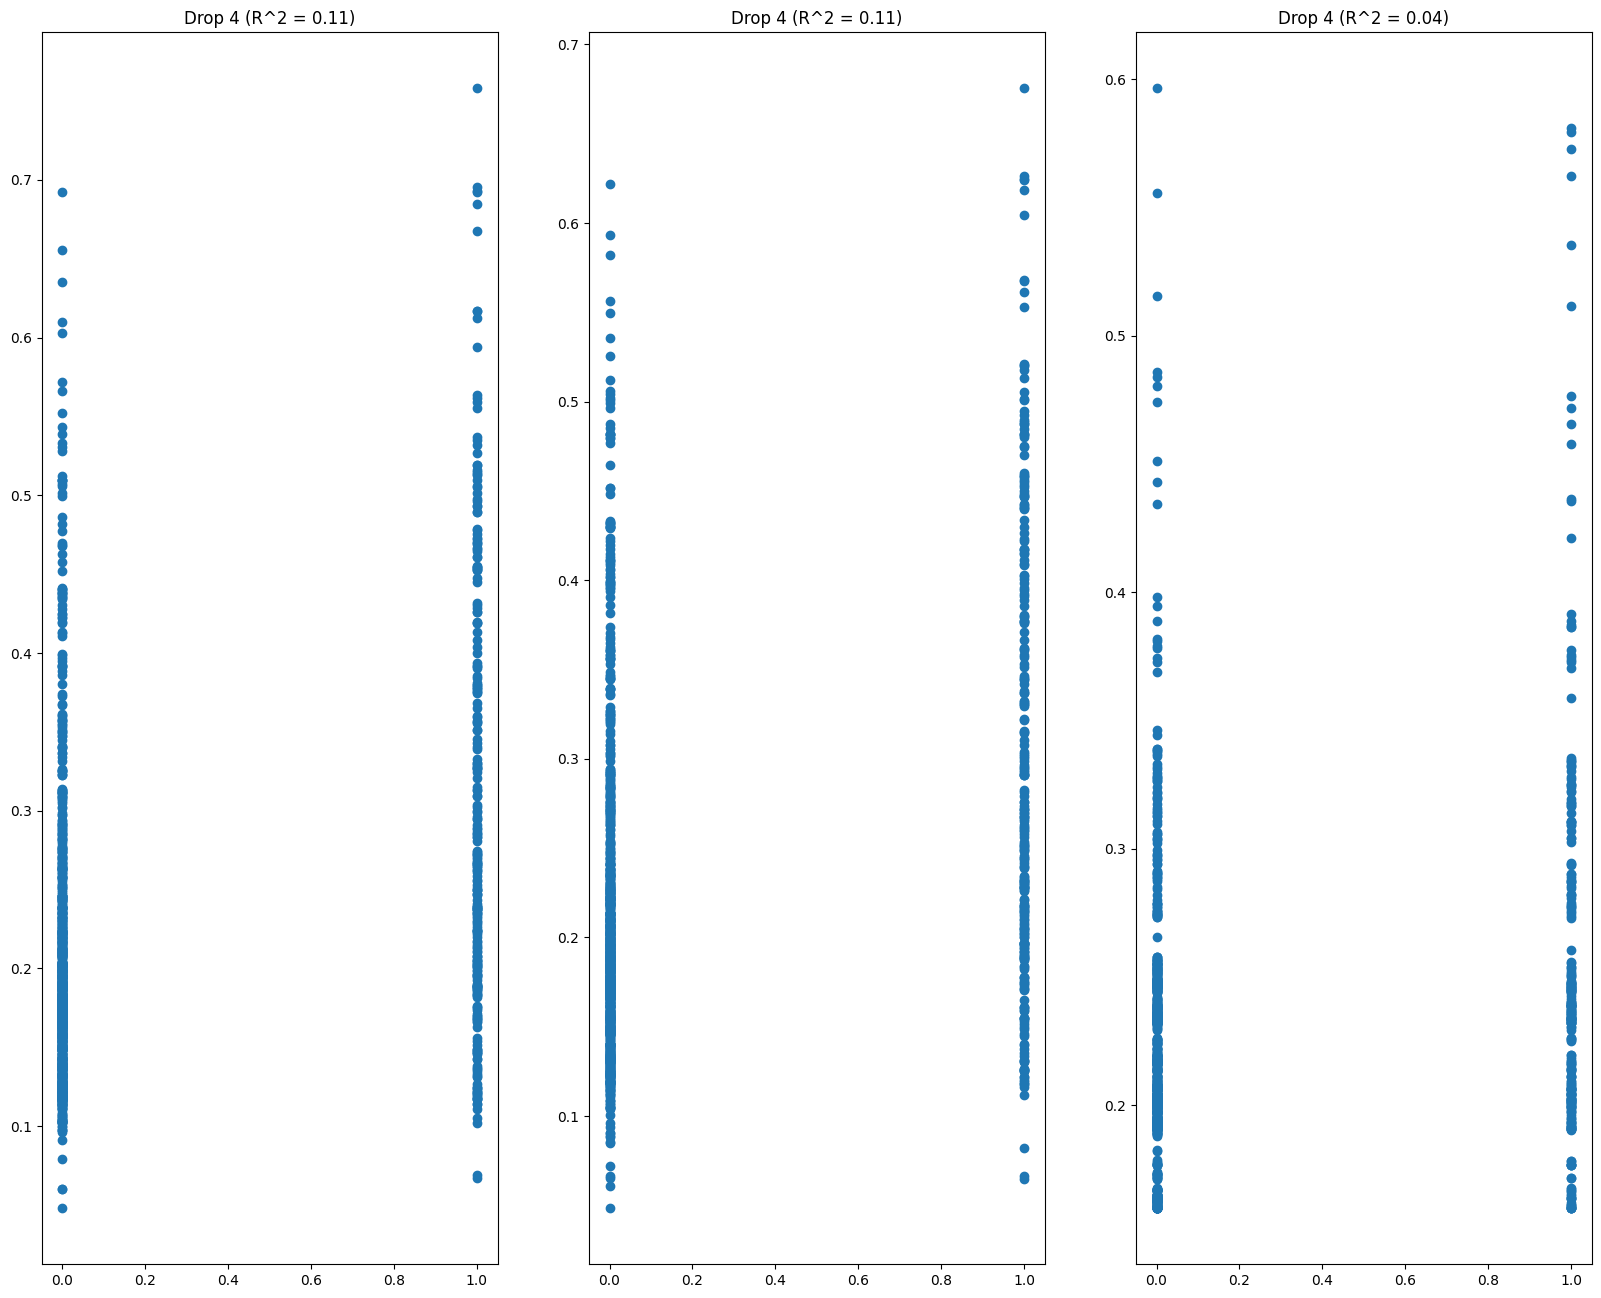

In [24]:
run_cate_masking_experiments(df, 
                             cov_results, 
                             treatment, 
                             y, 
                             train_idx, 
                             val_idx, 
                             extra_features=None,
                             true_cate=true_cate,
                             label_prefix="[CATE covs]",
                             max_steps=args.cate_max_steps)

## Experiment 3: Use DINO-V3 features to try to predict
Targets:
- outcome (direct prediction)
- treatment (perpensity)
- covariates (proxy)
- outcome + treatment (ignorability)

In [27]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler


class MultiTaskLinearEmbeddingModel(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        embedding_dim: int,
        regression_targets: int,
        classification_targets: int = 1,
    ) -> None:
        super().__init__()
        self.embedding = nn.Sequential(
            torch.nn.Linear(input_dim, input_dim * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim, embedding_dim),
        )
        self.bnneck = nn.BatchNorm1d(embedding_dim)
        self.regression_head = torch.nn.Linear(embedding_dim, regression_targets)
        self.classification_head = torch.nn.Linear(embedding_dim, classification_targets)

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor | None, torch.Tensor]:
        z = self.embedding(x)
        neck = self.bnneck(z)
        reg_out = self.regression_head(neck)
        cls_out = self.classification_head(neck)
        return reg_out, cls_out, z

def train_multitask_embedding(
    features: np.ndarray,
    outcome: np.ndarray,
    treatment: np.ndarray,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    embedding_dim: int,
    epochs: int,
    lr: float,
    random_state: int,
    curve_label: str | None = None,
) -> tuple[np.ndarray, float, float, float]:
    """Jointly train embeddings to predict covariates/outcome and classify treatment."""
    regression_targets = outcome.reshape(-1, 1)
    classification_targets = treatment.reshape(-1, 1)

    torch.manual_seed(random_state)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiTaskLinearEmbeddingModel(
        input_dim=features.shape[1],
        embedding_dim=embedding_dim,
        regression_targets=regression_targets.shape[1],
        classification_targets=classification_targets.shape[1],
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # mse_loss = torch.nn.MSELoss()
    bce_loss1 = torch.nn.BCEWithLogitsLoss()
    bce_loss2 = torch.nn.BCEWithLogitsLoss()

    X_train = torch.from_numpy(features[train_idx]).float().to(device)
    y_reg_train = torch.from_numpy(regression_targets[train_idx]).float().to(device)
    y_cls_train = torch.from_numpy(classification_targets[train_idx]).float().to(device)

    X_val = torch.from_numpy(features[val_idx]).float().to(device)
    y_reg_val = torch.from_numpy(regression_targets[val_idx]).float().to(device)
    y_cls_val = torch.from_numpy(classification_targets[val_idx]).float().to(device)

    batch_size = 128
    train_loss_history: List[float] = []
    val_metric_history: List[float] = []
    val_loss_history_reg = []
    val_loss_history_cls = []

    labels = y_cls_train.view(-1).long()  # shape [N], ints
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]   # weight per sample
    print(class_weights)

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_ds = TensorDataset(X_train, y_reg_train, y_cls_train)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,
        drop_last=True
    )

    for ep in range(epochs):
        model.train()
        losses = []
        for X_b, y_reg_b, y_cls_b in train_loader:
            optimizer.zero_grad()
            reg_preds, cls_preds, _ = model(X_b)
            mse = bce_loss1(reg_preds, y_reg_b)
            bce = bce_loss2(cls_preds, y_cls_b)
            loss = mse + bce
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())
        train_loss_history.append(float(np.mean(losses) if losses else 0.0))

        with torch.no_grad():
            reg_val_pred, cls_val_pred, _ = model(X_val)
            val_reg_loss = bce_loss1(reg_val_pred, y_reg_val)
            val_cls_loss = (
                bce_loss2(cls_val_pred, y_cls_val) if cls_val_pred is not None else 0.0
            )
            val_metric_history.append(float((val_reg_loss + val_cls_loss).item()))
            val_loss_history_cls.append(val_cls_loss.item())
            val_loss_history_reg.append(val_reg_loss.item())

    label = curve_label or "joint_embedding"
    plot_path = plot_training_curves(train_loss_history, val_metric_history, label)
    _ = plot_training_curves(val_loss_history_reg, val_loss_history_cls, "reg_cls_losses_val")
    print(f"Saved training curve plot to {plot_path}")

    with torch.no_grad():
        reg_val_pred, cls_val_pred, _ = model(X_val)
        outcome_preds = (
            torch.sigmoid(reg_val_pred).cpu().numpy()
            if reg_val_pred is not None
            else None
        )
        
        # reg_val_pred[:, -1]
        treatment_probs = (
            torch.sigmoid(cls_val_pred).cpu().numpy()
            if cls_val_pred is not None
            else None
        )

        cov_mae = 0
        outcome_acc = (
            accuracy_score(
                y_reg_val.cpu().numpy().ravel().astype(int),
                (outcome_preds >= 0.5).astype(int).ravel(),
            )
            if outcome_preds is not None
            else float("nan")
        )

        mean_absolute_error(
            y_reg_val[:, -1].cpu().numpy(),
            outcome_preds.cpu().numpy(),
        )
        treatment_acc = (
            accuracy_score(
                y_cls_val.cpu().numpy().ravel().astype(int),
                (treatment_probs >= 0.5).astype(int).ravel(),
            )
            if treatment_probs is not None
            else float("nan")
        )

        all_embeddings = (
            model.embedding(torch.from_numpy(features).float().to(device)).cpu().numpy()
        )

    return all_embeddings, cov_mae, outcome_acc, treatment_acc


#### Exp 3.0: Linear Regression to directly predict

In [6]:

print("\n[Features -> Covariates]")
for cov in covariates + ["outcome", "treatment"]:
    res = features_to_targets(features, df[cov], train_idx, val_idx, f"features -> {cov}")
    print(f"{cov:<12} MAE={res.mae:.4f} | R^2={res.r2:.4f}")



[Features -> Covariates]
urban        MAE=0.0000 | R^2=1.0000
tot_p        MAE=0.5608 | R^2=0.0355
tot_f        MAE=0.4343 | R^2=0.1634
outcome      MAE=0.3036 | R^2=0.1604
treatment    MAE=0.4482 | R^2=0.0058


We can see that all predictions fail with negative R^2, which means:

The linear prediction using the features is worse than random guess -> there is no linear relationship 

#### Exp 3.1: predict everything with feature
this is very important:
- ignorability should hold if we want to use CausalPFN
- that means:
    - Y - outcome
    - X - covariates (partially masked)
    - Z - features
    - T - treatment
    - ignorability: Y(0), Y(1) independent to T | Z, X
- if we want to replace X with Z: we can try
    - Z -> Y, T
    - Z -> X

In [7]:
df.head()

,row_id,urban,tot_p,tot_f,treatment,outcome
0,0,0,-0.512901,-0.069166,0.0,0
1,1,0,-0.340982,-0.296273,0.0,1
2,2,0,-0.472799,0.123807,0.0,1
3,3,0,-0.088488,-0.141045,0.0,0
4,4,0,-0.272289,-0.532896,0.0,0


In [8]:
args.embedding_lr = 0.0001
args.embedding_epochs = 100
for cov in covariates + ["outcome", "treatment"]:
    if cov in ["treatment", "urban", "outcome"]:
        cls = True
    else:
        cls = False
        
    embeddings, embed_val_mae, embed_val_r2 = train_linear_embedding(
        features,
        df[cov].to_numpy(),
        train_idx,
        val_idx,
        embedding_dim=args.embedding_dim,
        epochs=args.embedding_epochs,
        lr=args.embedding_lr,
        random_state=args.random_state,
        cls=cls,
        curve_label="curve_{}".format(cov),
    )
    print("Target:", cov, "mae:", embed_val_mae, "r2", embed_val_r2)

Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_urban_curve.png
Target: urban mae: 1.381654328724835e-07 r2 0.0
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_tot_p_curve.png
Target: tot_p mae: 0.5406035780906677 r2 0.08077758550643921
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_tot_f_curve.png
Target: tot_f mae: 0.30902308225631714 r2 0.1228894591331482
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amort

### Exp 3.2: train on outcome + treatment

In [ ]:

new_embeddings, cov_mae, outcome_mae, treatment_acc = train_multitask_embedding(
    features,
    y,
    treatment,
    train_idx,
    val_idx,
    embedding_dim=args.embedding_dim,
    epochs=100,
    lr=0.0001,
    random_state=args.random_state,
    curve_label="feat_joint_multitask",
)

tensor([0.0003, 0.0005])


KeyboardInterrupt: 

## Experiment 4: use graph as proxy to smooth the distribution
by using metric learning

see `metric_learning.py` -> downloads/metric_embeddings.pt

In [32]:
ml_embeddings = torch.load("data/shrug/metric_embeddings_multi.pt")['embeddings'].numpy()

In [34]:
args.embedding_lr = 0.00001
for cov in covariates + ["outcome", "treatment"]:
    if cov == "treatment":
        cls = True
    else:
        cls = False
        
    embeddings, embed_val_mae, embed_val_r2 = train_linear_embedding(
        ml_embeddings,
        df[cov].to_numpy(),
        train_idx,
        val_idx,
        embedding_dim=args.embedding_dim,
        epochs=args.embedding_epochs,
        lr=args.embedding_lr,
        random_state=args.random_state,
        cls=cls,
        curve_label="curve_ml_{}".format(cov),
    )
    print("Target:", cov, "mae:", embed_val_mae, "r2", embed_val_r2)

Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_ml_urban_curve.png
Target: urban mae: 0.004406508523970842 r2 0.0
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_ml_tot_p_curve.png
Target: tot_p mae: 0.5675374865531921 r2 0.002695024013519287
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/curve_ml_tot_f_curve.png
Target: tot_f mae: 0.314678817987442 r2 0.00017315149307250977
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making

## Experiment 5: use embeddings to test out CausalPFN

In [20]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=ml_embeddings,
    true_cate=true_cate,
    label_prefix="[CATE cov+feat]",
    max_steps=args.cate_max_steps,
)

[CATE cov+feat] baseline           -> MAE=0.2907 | R^2=0.2091 | CATE mean=-0.0442 std=0.0961
[CATE cov+feat] drop urban         -> MAE=0.2940 | R^2=0.1975 | CATE mean=-0.0467 std=0.0968
[CATE cov+feat] drop tot_p         -> MAE=0.3101 | R^2=0.1423 | CATE mean=-0.0436 std=0.1034
[CATE cov+feat] drop tot_f         -> MAE=0.3105 | R^2=0.1416 | CATE mean=-0.0579 std=0.0997


In [35]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=ml_embeddings,
    true_cate=true_cate,
    label_prefix="[CATE cov+feat]",
    max_steps=args.cate_max_steps,
)
# [CATE cov] baseline           -> MAE=0.2866 | R^2=0.2202 | CATE mean=-0.0383 std=0.1113
# [CATE cov] drop urban         -> MAE=0.2847 | R^2=0.2157 | CATE mean=-0.0403 std=0.1186
# [CATE cov] drop tot_p         -> MAE=0.2869 | R^2=0.2102 | CATE mean=-0.0411 std=0.1099
# [CATE cov] drop tot_f         -> MAE=0.2910 | R^2=0.1981 | CATE mean=-0.0421 std=0.1181

[CATE cov+feat] baseline           -> MAE=0.2892 | R^2=0.2045 | CATE mean=-0.0330 std=0.1020
[CATE cov+feat] drop urban         -> MAE=0.2946 | R^2=0.1907 | CATE mean=-0.0392 std=0.1100
[CATE cov+feat] drop tot_p         -> MAE=0.3107 | R^2=0.1399 | CATE mean=-0.0362 std=0.1113
[CATE cov+feat] drop tot_f         -> MAE=0.3127 | R^2=0.1352 | CATE mean=-0.0508 std=0.1047


## Experiment 5.1: ml embeddings -> train on outcome & treatment -> causalPFN

In [ ]:

new_embeddings, cov_mae, outcome_mae, treatment_acc = train_multitask_embedding(
    ml_embeddings,
    df[covariates].to_numpy(),
    y,
    treatment,
    train_idx,
    val_idx,
    embedding_dim=args.embedding_dim,
    epochs=200,
    lr=0.00001,
    random_state=args.random_state,
    curve_label="ml_joint_multitask",
)

(6055, 4)
tensor([0.0003, 0.0005])
Saved training curve plot to /Users/bob/Downloads/baidu_cloud/留学-UofT/Courses/csc2541 - causality/project-spaCE/Spatial-Decision-Making-with-Amortized-Causal-Methods/space_dataset/downloads/training_curves/ml_joint_multitask_curve.png


In [23]:

print("\n[New embeddings -> Covariates]")
for cov in covariates + ["outcome", "treatment"]:
    res = features_to_targets(new_embeddings, df[cov], train_idx, val_idx, f"new embeddings -> {cov}")
    print(f"{cov:<12} MAE={res.mae:.4f} | R^2={res.r2:.4f}")



[New embeddings -> Covariates]
urban        MAE=0.0000 | R^2=1.0000
tot_p        MAE=0.5516 | R^2=0.0383
tot_f        MAE=0.3244 | R^2=-0.0023
outcome      MAE=0.3241 | R^2=0.1035
treatment    MAE=0.4695 | R^2=-0.0074


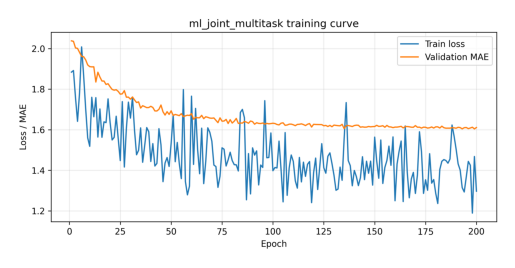

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path = './downloads/training_curves/ml_joint_multitask_curve.png'  # Replace with the actual path to your image

# Read the image using imread()
image_data = mpimg.imread(image_path)

# Display the image (optional)
plt.imshow(image_data)
plt.axis('off')  # Turn off axis labels and ticks for cleaner image display
plt.show()

In [25]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=new_embeddings,
    true_cate=true_cate,
    label_prefix="[CATE cov+feat]",
    max_steps=args.cate_max_steps,
)

[CATE cov+feat] baseline           -> MAE=0.2952 | R^2=0.1885 | CATE mean=-0.0341 std=0.0953
[CATE cov+feat] drop urban         -> MAE=0.2952 | R^2=0.1840 | CATE mean=-0.0374 std=0.0986
[CATE cov+feat] drop tot_p         -> MAE=0.3170 | R^2=0.1135 | CATE mean=-0.0466 std=0.1082
[CATE cov+feat] drop tot_f         -> MAE=0.3213 | R^2=0.1190 | CATE mean=-0.0440 std=0.1004


In [11]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=None,
    true_cate=None,
    label_prefix="[CATE cov]",
    max_steps=args.cate_max_steps,
)

[CATE cov] baseline           -> MAE=0.3221 | R^2=0.1104 | CATE mean=-0.0542 std=0.0570
[CATE cov] drop urban         -> MAE=0.3247 | R^2=0.1063 | CATE mean=-0.0525 std=0.0536
[CATE cov] drop tot_p         -> MAE=0.3438 | R^2=0.0420 | CATE mean=-0.0537 std=0.0418
BLAS : Bad memory unallocation! :  256  0x405630000
[CATE cov] drop tot_f         -> MAE=0.3585 | R^2=0.0071 | CATE mean=-0.0910 std=0.0000


In [12]:
run_cate_masking_experiments(
    df,
    cov_results,
    treatment,
    y,
    train_idx,
    val_idx,
    extra_features=features,
    true_cate=None,
    label_prefix="[CATE cov]",
    max_steps=args.cate_max_steps,
)

[CATE cov] baseline           -> MAE=0.2866 | R^2=0.2202 | CATE mean=-0.0383 std=0.1113
[CATE cov] drop urban         -> MAE=0.2847 | R^2=0.2157 | CATE mean=-0.0403 std=0.1186
[CATE cov] drop tot_p         -> MAE=0.2869 | R^2=0.2102 | CATE mean=-0.0411 std=0.1099
[CATE cov] drop tot_f         -> MAE=0.2910 | R^2=0.1981 | CATE mean=-0.0421 std=0.1181
